In [4]:
import gradio as gr
import matplotlib.pyplot as plt

from c_interop import Library
from common import Item
from skyline import skyline_decode
from ortools_models import task_one_model_adapter
from data_generator import guillotine_cutting, guillotine_cutting_max
from draw_utils import draw_cutting, draw_items_cnt, draw_side_bar

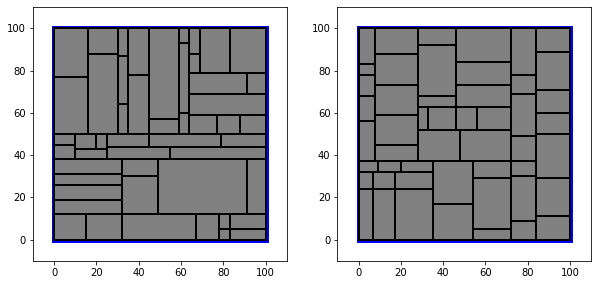

In [2]:
H, W = 100, 100
n_rect = 50
min_side = 5
seed = 5

items_xywh = [guillotine_cutting(W, H, n_rect, min_side, '', seed),
              guillotine_cutting_max(W, H, n_rect, min_side, seed)]

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
for i, items in enumerate(items_xywh):
    draw_cutting(H, W, items, ax=ax[i])

In [5]:
def to_wh(items_xywh):
    return [
            (w, h) if w > h else (h, w)
            for x, y, w, h in items_xywh
            ]

In [4]:
items_wh = [to_wh(items) for items in items_xywh]

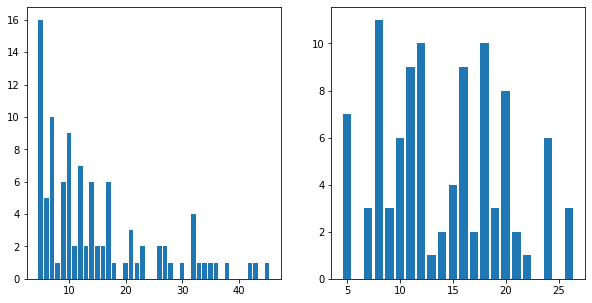

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
for i, items in enumerate(items_wh):
    draw_side_bar(items, ax=ax[i])

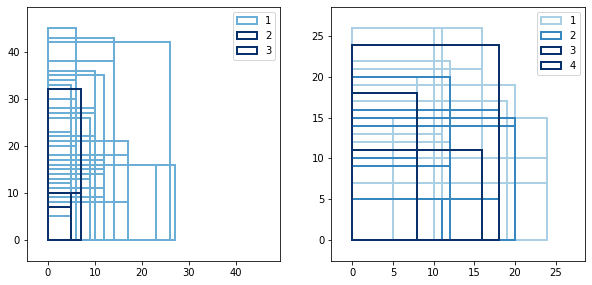

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
for i, items in enumerate(items_wh):
    draw_items_cnt(items, ax=ax[i])

In [ ]:
lib = Library('../lib/libcpp.dll')

algorithms = {'skyline': skyline_decode,
              'annealing': lib.get_function('simulated_annealing_skyline_auto'),
              'solver': task_one_model_adapter}

def demo_draw(W=100, H=100, num_rect=20, min_side=5, gen_type="max", random_seed=0, algorithm='none'):
    if "max" == gen_type:
        items_xywh = guillotine_cutting_max(W, H, num_rect, min_side, random_seed)
    elif "rand1" == gen_type:
        items_xywh = guillotine_cutting(W, H, num_rect, min_side, "", random_seed)
    else:
        items_xywh = guillotine_cutting(W, H, num_rect, min_side, "equal", random_seed)

    fig1, ax1 = plt.subplots()
    draw_cutting(H, W, items_xywh, ax=ax1)

    items_wh = to_wh(items_xywh)

    fig2, ax2 = plt.subplots()
    draw_items_cnt(items_wh, ax=ax2)

    fig3, ax3 = plt.subplots()
    draw_side_bar(items_wh, ax=ax3)

    result=W*H
    fig4, ax4 = plt.subplots()
    if algorithm!='none':
        items_cl = [Item(int(it[0]), int(it[1])) for it in items_wh]
        result,positions = algorithms[algorithm](int(W), int(H), items_cl)
        positions_xywh = [(
                pos.x,
                pos.y,
                it.width if not pos.rotated else it.height,
                it.height if not pos.rotated else it.width
                ) for it, pos in zip(items_cl, positions) if pos is not None]
        draw_cutting(H, W, positions_xywh, ax=ax4)
    info=f'Result is: {result} - {result/(W*H):.2%} of pallet is free'

    plt.close()
    return fig1, fig2, fig3, fig4,info


iface = gr.Interface(fn=demo_draw,
                     inputs=[
                             gr.inputs.Number(default=100, label="Pallet Width"),
                             gr.inputs.Number(default=100, label="Pallet Height"),
                             gr.inputs.Number(default=20, label="Number of rectangles"),
                             gr.inputs.Number(default=5, label="Minimum side length"),
                             gr.inputs.Radio(["max", "rand1", "rand2"], default="max", label="Generator type"),
                             gr.inputs.Number(default=0, label="Random seed"),
                             gr.inputs.Dropdown(['none']+list(algorithms.keys()),'value','none','Algorithm to solve')
                             ],
                     outputs=[
                             gr.outputs.Image(type="plot", label="Generated guillotine cutting"),
                             gr.outputs.Image(type="plot", label="Rectangles bar"),
                             gr.outputs.Image(type="plot", label="Side lenght bar"),
                             gr.outputs.Image(type="plot", label="Algorithm result"),
                             gr.outputs.Textbox(label='Result')
                             ],
                     live=False,
                     layout="unaligned",
                     title="Guillotine cutting demo",
                     verbose=True
                     )

iface.launch(debug = True)

Running locally at: http://127.0.0.1:7860/
To create a public link, set `share=True` in `launch()`.
Interface loading below...
